# LOYALTY TEST

## DSCI 100 (107) Group Project

Raj Dhillon (17571522), Diya, Oliver

### Introduction 

The "supermarket_sales.csv" dataset created by Aung Pyae on kaggle approximately 3 years ago will be manipulated for the project. The set contains data regarding 3 different supermarket branches sales across a 3 month period. 

Supermarket are often competing with one another due to demand for food and sanitary resources. Customer loyalty is one of key ingredients in having a profitable store, thus, the goal of the project is to perform classification to predict whether a person would be a store member or not based on gender, customer satisfaction rating, and total price of invoice.

The predictors used for the K-nearest neighbour classification in the project are: 
- *Gender* : The gender of the customer (1 = female, 2 = male)
- *Rating* : The customer satisfaction rating on the overall shopping experience (scale of 1 to 10)
- *Total* : Total price of goods including *unit_price*, *quantity*, and *Tax_5%*

Variable for which class will be predicted is: 
- *Customer_type* : Type of customer, either a member or not (recorded as 'member' for members and 'normal' for non-members)

Other variables from the dataset are not used as predictors since they display insignificant data with respect to classification. *Invoice ID*, *Branch*, *City*, *Date*, and *Time* are insignificant since they only help identify where the purchase was made and when. *unit_price*, *quantity* and *Tax_5%* variables are not displayed either since they are included in *total* which is an predictor. 

Through the following process, the predictors will be used to classify any customer either as a member or not a member (normal).

### Method and Reasoning for Classification with K-Nearest Neighbours

**What is classifcation with K-nearest neighbours**

Label of a new observation could be predicted with KNN-Classification. This form of classification finds the nearest or most similar observations to the new label in the training set and then predicts the label's class. The K in the classification represents the number of neighbours closest to the new observation and it is commonly chosen in advance. 

**Why is classifcation with K-nearest neighbours chosen over KNNR (K-nearest neighbour regression)**

There are two different tools that exist for statistical problems and they both utilize K-nearest neighbours (KNN). KNN is used for both classification and regression, with the difference between the two being related to how the output is calculated. KNN classification calculates it's output in a qualitative manner, however, KNN regression calculates the output in a quantitative form. Given that KNN classification calculates qualitatively, it would be appropriate to use classification sinc

In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
if (!require("stringr")) install.packages("stringr")
library('stringr')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [20]:
supermarket <- read_csv('supermarket_sales.csv')
    names(supermarket) <- str_replace_all(names(supermarket), " ", "_")

supermarket_sales <- supermarket%>%
    mutate(Customer_type = as_factor(Customer_type), Gender = as.numeric(as_factor(Gender)))
supermarket_sales%>%
    select(Gender, Total, Rating) %>%
    slice(1:5)


Parsed with column specification:
cols(
  `Invoice ID` = col_character(),
  Branch = col_character(),
  City = col_character(),
  `Customer type` = col_character(),
  Gender = col_character(),
  `Product line` = col_character(),
  `Unit price` = col_double(),
  Quantity = col_double(),
  `Tax 5%` = col_double(),
  Total = col_double(),
  Date = col_character(),
  Time = col_time(format = ""),
  Payment = col_character(),
  cogs = col_double(),
  `gross margin percentage` = col_double(),
  `gross income` = col_double(),
  Rating = col_double()
)



Gender,Total,Rating
<dbl>,<dbl>,<dbl>
1,548.9715,9.1
1,80.2200,9.6
2,340.5255,7.4
2,489.0480,8.4
2,634.3785,5.3


In [19]:
set.seed(1)
supermarket_split <- initial_split(supermarket_sales, prop = 0.70, strata = Customer_type) 
supermarket_train <- training(supermarket_split)
supermarket_test <- testing(supermarket_split)

supermarket_train%>%
    slice(1:5)

Invoice_ID,Branch,City,Customer_type,Gender,Product_line,Unit_price,Quantity,Tax_5%,Total,Date,Time,Payment,cogs,gross_margin_percentage,gross_income,Rating
<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<time>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
226-31-3081,C,Naypyitaw,Normal,1,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00,Cash,76.40,4.761905,3.8200,9.6
631-41-3108,A,Yangon,Normal,2,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23:00,Credit card,324.31,4.761905,16.2155,7.4
123-19-1176,A,Yangon,Member,2,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
373-73-7910,A,Yangon,Normal,2,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3
699-14-3026,C,Naypyitaw,Normal,2,Electronic accessories,85.39,7,29.8865,627.6165,3/25/2019,18:30:00,Ewallet,597.73,4.761905,29.8865,4.1


In [6]:
supermarket_recipe <- recipe(Customer_type ~ Gender + Total + Rating , data = supermarket_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
supermarket_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [7]:
supermarket_vfold <- vfold_cv(supermarket_train, v = 5, strata = Customer_type)


In [8]:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [10]:
supermarket_workflow <- workflow()%>%
     add_recipe(supermarket_recipe) %>%
     add_model(knn_spec) %>%
     tune_grid(resamples = supermarket_vfold, grid = 10)%>%
     collect_metrics()
supermarket_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4864539,5,0.017726592,Model1
1,roc_auc,binary,0.4864789,5,0.017725136,Model1
2,accuracy,binary,0.4864539,5,0.017726592,Model2
2,roc_auc,binary,0.4677002,5,0.010096807,Model2
4,accuracy,binary,0.4693516,5,0.007592770,Model3
4,roc_auc,binary,0.4479874,5,0.007015656,Model3
6,accuracy,binary,0.4664843,5,0.008412031,Model4
6,roc_auc,binary,0.4584432,5,0.015858871,Model4
7,accuracy,binary,0.4821682,5,0.006585438,Model5


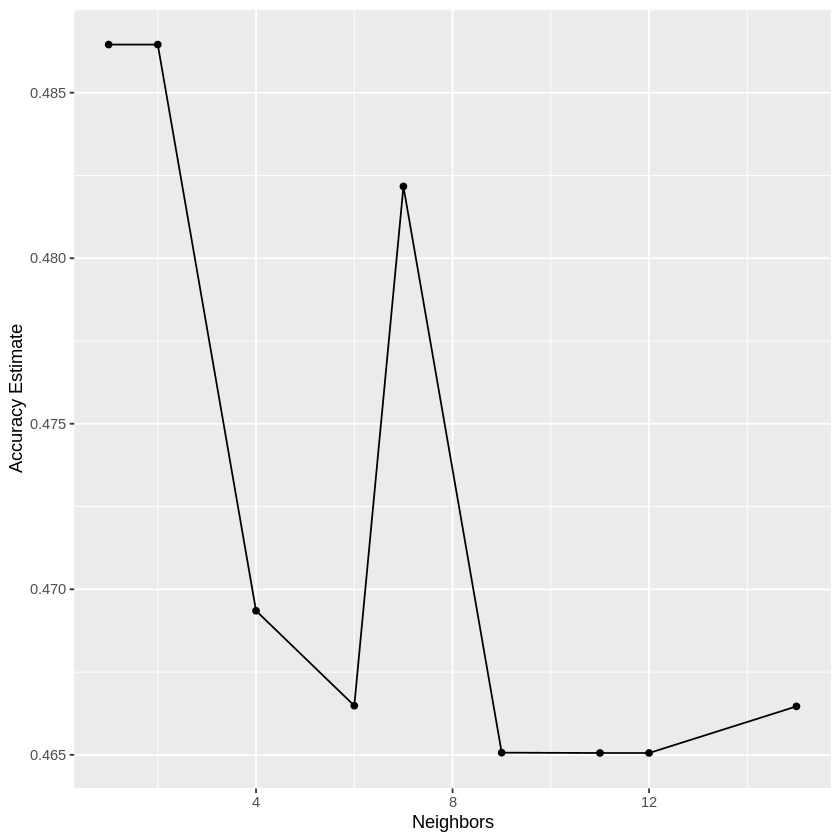

In [11]:
supermarket_accuracies <- supermarket_workflow%>%
    filter(.metric == 'accuracy')
 
cross_val_plot <- ggplot(supermarket_accuracies, aes(x = neighbors, y = mean)) +
    geom_point()+
    geom_line()+
    labs(x = 'Neighbors', y = 'Accuracy Estimate')

cross_val_plot



In [14]:
supermarket_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2)%>% 
    set_engine('kknn') %>%
    set_mode('classification')

supermarket_fit <- supermarket_workflow <- workflow()%>%
     add_recipe(supermarket_recipe) %>%
     add_model(supermarket_spec) %>%
     fit(data = supermarket_train)
supermarket_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~2, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5121255
Best kernel: rectangular
Best k: 2